## Uczenie maszynowe – zastosowania
# 10. Sieci neuronowe – propagacja wsteczna

In [1]:
%matplotlib inline

import numpy as np
import math

## 10.1. Metoda propagacji wstecznej – wprowadzenie

<img src="nn1.png" width="70%"/>

### Architektura sieci neuronowych

* Budowa warstwowa, najczęściej sieci jednokierunkowe i gęste.
* Liczbę i rozmiar warstw dobiera się do każdego problemu.
* Rozmiary sieci określane poprzez liczbę neuronów lub parametrów.

### _Feedforward_

Mając daną $n$-warstwową sieć neuronową oraz jej parametry $\Theta^{(1)}, \ldots, \Theta^{(L)} $ oraz $\beta^{(1)}, \ldots, \beta^{(L)} $, obliczamy:

$$a^{(l)} = g^{(l)}\left( a^{(l-1)} \Theta^{(l)} + \beta^{(l)} \right). $$

<img src="nn2.png" width="70%"/>

* Funkcje $g^{(l)}$ to **funkcje aktywacji**.<br/>
Dla $i = 0$ przyjmujemy $a^{(0)} = x$ (wektor wierszowy cech) oraz $g^{(0)}(x) = x$ (identyczność).

* Parametry $\Theta$ to wagi na połączeniach miedzy neuronami dwóch warstw.<br/>
Rozmiar macierzy $\Theta^{(l)}$, czyli macierzy wag na połączeniach warstw $a^{(l-1)}$ i $a^{(l)}$, to $\dim(a^{(l-1)}) \times \dim(a^{(l)})$.

* Parametry $\beta$ zastępują tutaj dodawanie kolumny z jedynkami do macierzy cech.<br/>Macierz $\beta^{(l)}$ ma rozmiar równy liczbie neuronów w odpowiedniej warstwie, czyli $1 \times \dim(a^{(l)})$.

* **Klasyfikacja**: dla ostatniej warstwy $L$ (o rozmiarze równym liczbie klas) przyjmuje się $g^{(L)}(x) = \mathop{\mathrm{softmax}}(x)$.
* **Regresja**: pojedynczy neuron wyjściowy; funkcją aktywacji może wtedy być np. funkcja identycznościowa.

* Pozostałe funkcje aktywacji najcześciej mają postać sigmoidy, np. sigmoidalna, tangens hiperboliczny.<br/> Ale niekoniecznie, np. ReLU, leaky ReLU, maxout.

### Jak uczyć sieci neuronowe?

* W poznanych do tej pory algorytmach (regresja liniowa, regresja logistyczna) do uczenia używaliśmy funkcji kosztu, jej gradientu oraz algorytmu gradientu prostego (GD/SGD)

* Dla sieci neuronowych potrzebowalibyśmy również znaleźć gradient funkcji kosztu.

* Co sprowadza się do bardziej ogólnego problemu:<br/>jak obliczyć gradient $\nabla f(x)$ dla danej funkcji $f$ i wektora wejściowego $x$?

### Pochodna funkcji

* **Pochodna** mierzy, jak szybko zmienia się wartość funkcji względem zmiany jej argumentów:

$$ \frac{d f(x)}{d x} = \lim_{h \to 0} \frac{ f(x + h) - f(x) }{ h } $$

### Pochodna cząstkowa i gradient

* **Pochodna cząstkowa** mierzy, jak szybko zmienia się wartość funkcji względem zmiany jej *pojedynczego argumentu*.

* **Gradient** to wektor pochodnych cząstkowych:

$$ \nabla f = \left( \frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n} \right) $$

### Gradient – przykłady

$$ f(x_1, x_2) = x_1 + x_2 \qquad \to \qquad \frac{\partial f}{\partial x_1} = 1, \quad \frac{\partial f}{\partial x_2} = 1, \quad \nabla f = (1, 1) $$ 

$$ f(x_1, x_2) = x_1 \cdot x_2 \qquad \to \qquad \frac{\partial f}{\partial x_1} = x_2, \quad \frac{\partial f}{\partial x_2} = x_1, \quad \nabla f = (x_2, x_1) $$ 

$$ f(x_1, x_2) = \max(x_1 + x_2) \hskip{12em} \\
\to \qquad \frac{\partial f}{\partial x_1} = \mathbb{1}_{x \geq y}, \quad \frac{\partial f}{\partial x_2} = \mathbb{1}_{y \geq x}, \quad \nabla f = (\mathbb{1}_{x \geq y}, \mathbb{1}_{y \geq x}) $$ 

### Własności pochodnych cząstkowych

Jezeli $f(x, y, z) = (x + y) \, z$ oraz $x + y = q$, to:
$$f = q z,
\quad \frac{\partial f}{\partial q} = z,
\quad \frac{\partial f}{\partial z} = q,
\quad \frac{\partial q}{\partial x} = 1,
\quad \frac{\partial q}{\partial y} = 1 $$

### Reguła łańcuchowa

$$ \frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \, \frac{\partial q}{\partial x},
\quad \frac{\partial f}{\partial y} = \frac{\partial f}{\partial q} \, \frac{\partial q}{\partial y} $$

### Propagacja wsteczna – prosty przykład

In [2]:
# Dla ustalonego wejścia
x = -2; y = 5; z = -4

In [3]:
# Krok w przód
q = x + y
f = q * z
print(q, f)

(3, -12)


In [4]:
# UWAGA: teraz za pomocą zmiennych `dfx`, `dfy`, `dfz` i `dfq`
# oznaczę pochodne cząstkowe ∂f/∂x, ∂f/∂y, ∂f/∂z i ∂f/∂q odpowiednio

# Propagacja wsteczna dla f = q * z
dfz = q
dfq = z
# Propagacja wsteczna dla q = x + y
dfx = 1 * dfq  # z reguły łańcuchowej
dfy = 1 * dfq  # z reguły łańcuchowej
print([dfx, dfy, dfz])

[-4, -4, 3]


<img src="exp1.png" />

* Właśnie tak wygląda obliczanie pochodnych metodą propagacji wstecznej!

* Spróbujmy czegoś bardziej skomplikowanego:<br/>metodą propagacji wstecznej obliczmy pochodną funkcji sigmoidalnej.

### Propagacja wsteczna – funkcja sigmoidalna

Funkcja sigmoidalna:

$$f(\theta,x) = \frac{1}{1+e^{-(\theta_0 x_0 + \theta_1 x_1 + \theta_2)}}$$

$$
\begin{array}{lcl}
f(x) = \frac{1}{x} \quad & \rightarrow & \quad \frac{df}{dx} = -\frac{1}{x^2} \\
f_c(x) = c + x \quad & \rightarrow & \quad \frac{df}{dx} = 1 \\
f(x) = e^x \quad & \rightarrow & \quad \frac{df}{dx} = e^x \\
f_a(x) = ax \quad & \rightarrow & \quad \frac{df}{dx} = a \\
\end{array}
$$

<img src="exp2.png" />

In [5]:
# Losowe wagi i dane
w = [2,-3,-3]
x = [-1, -2]

# Krok w przód
dot = w[0]*x[0] + w[1]*x[1] + w[2]
f = 1.0 / (1 + math.exp(-dot))  # funkcja sigmoidalna

# Krok w tył
ddot = (1 - f) * f  # pochodna funkcji sigmoidalnej
dx = [w[0] * ddot, w[1] * ddot]
dw = [x[0] * ddot, x[1] * ddot, 1.0 * ddot]

print(dx)
print(dw)

[0.3932238664829637, -0.5898357997244456]
[-0.19661193324148185, -0.3932238664829637, 0.19661193324148185]


### Obliczanie gradientów – podsumowanie

* Gradient $f$ dla $x$ mówi jak zmieni się całe wyrażenie przy zmianie wartości $x$.
* Gradienty łączymy korzystając z **reguły łańcuchowej**.
* W kroku wstecz gradienty informują, które części grafu powinny być zwiększone lub zmniejszone (i z jaką siłą), aby zwiększyć wartość na wyjściu.
* W kontekście implementacji chcemy dzielić funkcję $f$ na części, dla których można łatwo obliczyć gradienty.

## 10.2. Uczenie wielowarstwowych sieci neuronowych metodą propagacji wstecznej

Mając algorytm SGD oraz gradienty wszystkich wag, moglibyśmy trenować każdą sieć.

* Niech:
$$\Theta = (\Theta^{(1)},\Theta^{(2)},\Theta^{(3)},\beta^{(1)},\beta^{(2)},\beta^{(3)})$$

* Funkcja sieci neuronowej z grafiki:

$$\small h_\Theta(x) = \tanh(\tanh(\tanh(x\Theta^{(1)}+\beta^{(1)})\Theta^{(2)} + \beta^{(2)})\Theta^{(3)} + \beta^{(3)})$$
* Funkcja kosztu dla regresji:
$$J(\Theta) = \dfrac{1}{2m} \sum_{i=1}^{m} (h_\Theta(x^{(i)})- y^{(i)})^2 $$

* Jak obliczymy gradienty?

$$\nabla_{\Theta^{(l)}} J(\Theta) = ? \quad \nabla_{\beta^{(l)}} J(\Theta) = ?$$

### W kierunku propagacji wstecznej

* Pewna (niewielka) zmiana wagi $\Delta z^l_j$ dla $j$-ego neuronu w warstwie $l$ pociąga za sobą (niewielką) zmianę kosztu: 

$$\frac{\partial J(\Theta)}{\partial z^{l}_j}  \Delta z^{l}_j$$

* Jeżeli $\frac{\partial J(\Theta)}{\partial z^{l}_j}$ jest duża, $\Delta z^l_j$ ze znakiem przeciwnym zredukuje koszt.
* Jeżeli $\frac{\partial J(\Theta)}{\partial z^l_j}$ jest bliska zeru, koszt nie będzie mocno poprawiony.

* Definiujemy błąd $\delta^l_j$ neuronu $j$ w warstwie $l$: 

$$\delta^l_j := \dfrac{\partial J(\Theta)}{\partial z^l_j}$$ 
$$\delta^l := \nabla_{z^l} J(\Theta) \quad \textrm{ (zapis wektorowy)} $$

### Podstawowe równania propagacji wstecznej

$$
\begin{array}{rcll}
\delta^L & = & \nabla_{a^L}J(\Theta) \odot { \left( g^{L} \right) }^{\prime} \left( z^L \right) & (BP1) \\[2mm]
\delta^{l} & = & \left( \left( \Theta^{l+1} \right) \! ^\top \, \delta^{l+1} \right) \odot {{ \left( g^{l} \right) }^{\prime}} \left( z^{l} \right) & (BP2)\\[2mm]
\nabla_{\beta^l} J(\Theta) & = & \delta^l & (BP3)\\[2mm]
\nabla_{\Theta^l} J(\Theta) & = & a^{l-1} \odot \delta^l & (BP4)\\
\end{array}
$$


#### (BP1)
$$ \delta^L_j \; = \; \frac{ \partial J }{ \partial a^L_j } \, g' \!\! \left( z^L_j \right) $$
$$ \delta^L \; = \; \nabla_{a^L}J(\Theta) \odot { \left( g^{L} \right) }^{\prime} \left( z^L \right) $$
Błąd w ostatniej warstwie jest iloczynem szybkości zmiany kosztu względem $j$-tego wyjścia i szybkości zmiany funkcji aktywacji w punkcie $z^L_j$.

#### (BP2)
$$ \delta^{l} \; = \; \left( \left( \Theta^{l+1} \right) \! ^\top \, \delta^{l+1} \right) \odot {{ \left( g^{l} \right) }^{\prime}} \left( z^{l} \right) $$
Aby obliczyć błąd w $l$-tej warstwie, należy przemnożyć błąd z następnej ($(l+1)$-szej) warstwy przez transponowany wektor wag, a uzyskaną macierz pomnożyć po współrzędnych przez szybkość zmiany funkcji aktywacji w punkcie $z^l$.

#### (BP3)
$$ \nabla_{\beta^l} J(\Theta) \; = \; \delta^l $$
Błąd w $l$-tej warstwie jest równy wartości gradientu funkcji kosztu.

#### (BP4)
$$ \nabla_{\Theta^l} J(\Theta) \; = \; a^{l-1} \odot \delta^l $$
Gradient funkcji kosztu względem wag $l$-tej warstwy można obliczyć jako iloczyn po współrzędnych $a^{l-1}$ przez $\delta^l$.

### Algorytm propagacji wstecznej

Dla jednego przykładu $(x,y)$:

1. **Wejście**: Ustaw aktywacje w warstwie cech $a^{(0)}=x$ 
2. **Feedforward:** dla $l=1,\dots,L$ oblicz 
$$z^{(l)} = a^{(l-1)} \Theta^{(l)} + \beta^{(l)} \textrm{ oraz } a^{(l)}=g^{(l)} \!\! \left( z^{(l)} \right) $$
3. **Błąd wyjścia $\delta^{(L)}$:** oblicz wektor $$\delta^{(L)}= \nabla_{a^{(L)}}J(\Theta) \odot {g^{\prime}}^{(L)} \!\! \left( z^{(L)} \right) $$
4. **Propagacja wsteczna błędu:** dla $l = L-1,L-2,\dots,1$ oblicz $$\delta^{(l)} = \delta^{(l+1)}(\Theta^{(l+1)})^T \odot {g^{\prime}}^{(l)} \!\! \left( z^{(l)} \right) $$
5. **Gradienty:** 
    * $\dfrac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = a_i^{(l-1)}\delta_j^{(l)} \textrm{ oraz } \dfrac{\partial}{\partial \beta_{j}^{(l)}} J(\Theta) = \delta_j^{(l)}$

W naszym przykładzie:

$$\small J(\Theta) = \frac{1}{2} \left( a^{(L)} - y \right) ^2 $$
$$\small  \dfrac{\partial}{\partial a^{(L)}} J(\Theta) = a^{(L)} - y$$

$$\small \tanh^{\prime}(x) = 1 - \tanh^2(x)$$

<img src="nn3.png" />

### Algorytm SGD z propagacją wsteczną

Pojedyncza iteracja:
* Dla parametrów $\Theta = (\Theta^{(1)},\ldots,\Theta^{(L)})$ utwórz pomocnicze macierze zerowe $\Delta = (\Delta^{(1)},\ldots,\Delta^{(L)})$ o takich samych wymiarach (dla uproszczenia opuszczono wagi $\beta$).
* Dla $m$ przykładów we wsadzie (_batch_), $i = 1,\ldots,m$:
    * Wykonaj algortym propagacji wstecznej dla przykładu $(x^{(i)}, y^{(i)})$ i przechowaj gradienty $\nabla_{\Theta}J^{(i)}(\Theta)$ dla tego przykładu;
    * $\Delta := \Delta + \dfrac{1}{m}\nabla_{\Theta}J^{(i)}(\Theta)$
* Wykonaj aktualizację wag: $\Theta := \Theta - \alpha \Delta$

### Propagacja wsteczna – podsumowanie

* Algorytm pierwszy raz wprowadzony w latach 70. XX w.
* W 1986 David Rumelhart, Geoffrey Hinton i Ronald Williams pokazali, że jest znacznie szybszy od wcześniejszych metod.
* Obecnie najpopularniejszy algorytm uczenia sieci neuronowych.

## 10.3. Przykłady implementacji wielowarstwowych sieci neuronowych

### Uwaga!

Poniższe przykłady wykorzystują interfejs [Keras](https://keras.io), który jest częścią biblioteki [TensorFlow](https://www.tensorflow.org).

Aby uruchomić TensorFlow w środowisku Jupyter, należy wykonać następujące czynności:

#### Przed pierwszym uruchomieniem (wystarczy wykonać tylko raz)

Instalacja biblioteki TensorFlow w środowisku Anaconda:

1. Uruchom *Anaconda Navigator*
1. Wybierz kafelek *CMD.exe Prompt*
1. Kliknij przycisk *Launch*
1. Pojawi się konsola. Wpisz następujące polecenia, każde zatwierdzając wciśnięciem klawisza Enter:
```
conda create -n tf tensorflow
conda activate tf
conda install pandas matplotlib
jupyter notebook
```

#### Przed każdym uruchomieniem

Jeżeli chcemy korzystać z biblioteki TensorFlow, to środowisko Jupyter Notebook należy uruchomić w następujący sposób:

1. Uruchom *Anaconda Navigator*
1. Wybierz kafelek *CMD.exe Prompt*
1. Kliknij przycisk *Launch*
1. Pojawi się konsola. Wpisz następujące polecenia, każde zatwierdzając wciśnięciem klawisza Enter:
```
conda activate tf
jupyter notebook
```

### Przykład: MNIST

_Modified National Institute of Standards and Technology database_

* Zbiór cyfr zapisanych pismem odręcznym
* 60 000 przykładów uczących, 10 000 przykładów testowych
* Rozdzielczość każdego przykładu: 28 × 28 = 784 piksele

In [1]:
# źródło: https://github.com/keras-team/keras/examples/minst_mlp.py

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout

# załaduj dane i podziel je na zbiory uczący i testowy
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
from matplotlib import pyplot as plt

def draw_examples(examples, captions=None):
    plt.figure(figsize=(16, 4))
    m = len(examples)
    for i, example in enumerate(examples):
        plt.subplot(100 + m * 10 + i + 1)
        plt.imshow(example, cmap=plt.get_cmap('gray'))
    plt.show()
    if captions is not None:
        print(6 * ' ' + (10 * ' ').join(str(captions[i]) for i in range(m)))

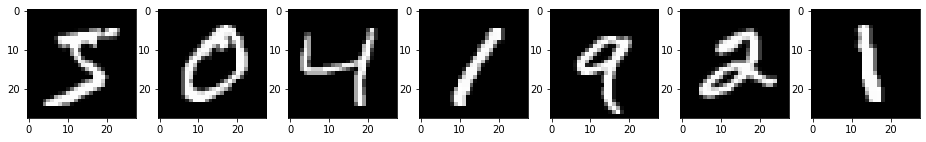

      5          0          4          1          9          2          1


In [3]:
draw_examples(x_train[:7], captions=y_train)

In [4]:
num_classes = 10

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('{} przykładów uczących'.format(x_train.shape[0]))
print('{} przykładów testowych'.format(x_test.shape[0]))

# przekonwertuj wektory klas na binarne macierze klas
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 przykładów uczących
10000 przykładów testowych


In [9]:
model = keras.Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()  # wyświetl podsumowanie architektury sieci

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000, 10)


In [12]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0957 - accuracy: 0.9708 - val_loss: 0.0824 - val_accuracy: 0.9758
Epoch 2/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0693 - accuracy: 0.9793 - val_loss: 0.0807 - val_accuracy: 0.9772
Epoch 3/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0563 - accuracy: 0.9827 - val_loss: 0.0861 - val_accuracy: 0.9758
Epoch 4/10
469/469 [==============================] - 18s 37ms/step - loss: 0.0485 - accuracy: 0.9857 - val_loss: 0.0829 - val_accuracy: 0.9794
Epoch 5/10
469/469 [==============================] - 19s 41ms/step - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0955 - val_accuracy: 0.9766
Epoch 6/10
469/469 [==============================] - 22s 47ms/step - loss: 0.0377 - accuracy: 0.9887 - val_loss: 0.0809 - val_accuracy: 0.9794
Epoch 7/10
469/469 [==============================] - 17s 35ms/step - loss: 0.0338 - accuracy: 0.9904 - val_loss: 0.1028 - val_accuracy:

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.0757974311709404
Test accuracy: 0.9810000061988831


Warstwa *dropout* to metoda regularyzacji, służy zapobieganiu nadmiernemu dopasowaniu sieci. Polega na tym, że część węzłów sieci jest usuwana w sposób losowy.

In [61]:
# Bez warstw Dropout

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_no_dropout = keras.Sequential()
model_no_dropout.add(Dense(512, activation='relu', input_shape=(784,)))
model_no_dropout.add(Dense(512, activation='relu'))
model_no_dropout.add(Dense(num_classes, activation='softmax'))
model_no_dropout.summary()

model_no_dropout.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.RMSprop(),
                         metrics=['accuracy'])

model_no_dropout.fit(x_train, y_train,
                     batch_size=128,
                     epochs=5,
                     verbose=1,
                     validation_data=(x_test, y_test))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_63 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_64 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
469/469 [==============================] - 10s 20ms/step - loss: 0.2203 - accuracy: 0.9317 - val_loss: 0.0936 - val_accuracy: 0.9697
Epoch 2/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0816 - accuracy: 0.9746 - val_loss: 0.0747 - val_accuracy: 0.9779
Epoch 3/5
469/469 [==============================] - 10s 20ms/step - loss: 0.0544 - accurac

In [62]:
# Bez warstw Dropout

score = model_no_dropout.evaluate(x_test, y_test, verbose=0)

print('Test loss (no dropout): {}'.format(score[0]))
print('Test accuracy (no dropout): {}'.format(score[1]))

Test loss (no dropout): 0.07358124107122421
Test accuracy (no dropout): 0.9800999760627747


In [63]:
# Więcej warstw, inna funkcja aktywacji

num_classes = 10

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)  # 784 = 28 * 28
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model3 = Sequential()
model3.add(Dense(2500, activation='tanh', input_shape=(784,)))
model3.add(Dense(2000, activation='tanh'))
model3.add(Dense(1500, activation='tanh'))
model3.add(Dense(1000, activation='tanh'))
model3.add(Dense(500, activation='tanh'))
model3.add(Dense(num_classes, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.RMSprop(),
               metrics=['accuracy'])

model3.fit(x_train, y_train,
           batch_size=128,
           epochs=10,
           verbose=1,
           validation_data=(x_test, y_test))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 2500)              1962500   
_________________________________________________________________
dense_66 (Dense)             (None, 2000)              5002000   
_________________________________________________________________
dense_67 (Dense)             (None, 1500)              3001500   
_________________________________________________________________
dense_68 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_69 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_70 (Dense)             (None, 10)                5010      
Total params: 11,972,510
Trainable params: 11,972,510
Non-trainable params: 0
_________________________________________

In [64]:
# Więcej warstw, inna funkcja aktywacji

score = model3.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.10945799201726913
Test accuracy: 0.9697999954223633


### Przykład: 4-pikselowy aparat fotograficzny

https://www.youtube.com/watch?v=ILsA4nyG7I0

In [65]:
def generate_example(description):
    variant = random.choice([1, -1])
    if description == 's':  # solid
        return (np.array([[ 1.0,  1.0], [ 1.0,  1.0]]) if variant == 1 else
                np.array([[-1.0, -1.0], [-1.0, -1.0]]))
    elif description == 'v':  # vertical
        return (np.array([[ 1.0, -1.0], [ 1.0, -1.0]]) if variant == 1 else
                np.array([[-1.0,  1.0], [-1.0,  1.0]]))
    elif description == 'd':  # diagonal
        return (np.array([[ 1.0, -1.0], [-1.0,  1.0]]) if variant == 1 else
                np.array([[-1.0,  1.0], [ 1.0, -1.0]]))
    elif description == 'h':  # horizontal
        return (np.array([[ 1.0,  1.0], [-1.0, -1.0]]) if variant == 1 else
                np.array([[-1.0, -1.0], [ 1.0,  1.0]]))
    else:
        return np.array([[random.uniform(-1, 1), random.uniform(-1, 1)],
                         [random.uniform(-1, 1), random.uniform(-1, 1)]])

In [67]:
import random

num_classes = 4

trainset_size = 4000
testset_size = 1000

y4_train = np.array([random.choice(['s', 'v', 'd', 'h']) for i in range(trainset_size)])
x4_train = np.array([generate_example(desc) for desc in y4_train])

y4_test = np.array([random.choice(['s', 'v', 'd', 'h']) for i in range(testset_size)])
x4_test = np.array([generate_example(desc) for desc in y4_test])

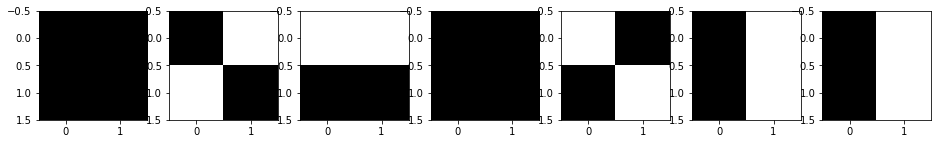

      s          d          h          s          d          v          v


In [68]:
draw_examples(x4_train[:7], captions=y4_train)

In [69]:
x4_train = x4_train.reshape(trainset_size, 4)
x4_test = x4_test.reshape(testset_size, 4)
x4_train = x4_train.astype('float32')
x4_test = x4_test.astype('float32')

y4_train = np.array([{'s': 0, 'v': 1, 'd': 2, 'h': 3}[desc] for desc in y4_train])
y4_test = np.array([{'s': 0, 'v': 1, 'd': 2, 'h': 3}[desc] for desc in y4_test])

y4_train = keras.utils.to_categorical(y4_train, num_classes)
y4_test = keras.utils.to_categorical(y4_test, num_classes)

In [70]:
model4 = keras.Sequential()
model4.add(Dense(4, activation='tanh', input_shape=(4,)))
model4.add(Dense(4, activation='tanh'))
model4.add(Dense(8, activation='relu'))
model4.add(Dense(num_classes, activation='softmax'))
model4.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_73 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_74 (Dense)             (None, 4)                 36        
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [71]:
model4.layers[0].set_weights(
    [np.array([[ 1.0,  0.0,  1.0,  0.0],
               [ 0.0,  1.0,  0.0,  1.0],
               [ 1.0,  0.0, -1.0,  0.0],
               [ 0.0,  1.0,  0.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])
model4.layers[1].set_weights(
    [np.array([[ 1.0, -1.0,  0.0,  0.0],
               [ 1.0,  1.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0, -1.0],
               [ 0.0,  0.0, -1.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])
model4.layers[2].set_weights(
    [np.array([[ 1.0, -1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0, -1.0,  0.0,  0.0,  0.0,  0.0],
               [ 0.0,  0.0,  0.0,  0.0,  1.0, -1.0,  0.0,  0.0],
               [ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  1.0, -1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=np.float32)])

In [73]:
model4.layers[3].set_weights(
    [np.array([[ 1.0,  0.0,  0.0,  0.0],
               [ 1.0,  0.0,  0.0,  0.0],
               [ 0.0,  1.0,  0.0,  0.0],
               [ 0.0,  1.0,  0.0,  0.0],
               [ 0.0,  0.0,  1.0,  0.0],
               [ 0.0,  0.0,  1.0,  0.0],
               [ 0.0,  0.0,  0.0,  1.0],
               [ 0.0,  0.0,  0.0,  1.0]],
              dtype=np.float32), np.array([0., 0., 0., 0.], dtype=np.float32)])

model4.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adagrad(),
               metrics=['accuracy'])

In [74]:
for layer in model4.layers:
    print(layer.get_weights())

[array([[ 1.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  1.],
       [ 1.,  0., -1.,  0.],
       [ 0.,  1.,  0., -1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -1.],
       [ 0.,  0., -1., -1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]
[array([[ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32), array([0., 0., 0., 0.], dtype=float32)]


In [75]:
model4.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

array([[0.17831734, 0.17831734, 0.17831734, 0.465048  ]], dtype=float32)

In [76]:
score = model4.evaluate(x4_test, y4_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.7656148672103882
Test accuracy: 1.0


In [77]:
model5 = Sequential()
model5.add(Dense(4, activation='tanh', input_shape=(4,)))
model5.add(Dense(4, activation='tanh'))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.RMSprop(),
               metrics=['accuracy'])
model5.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_77 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 36        
Total params: 116
Trainable params: 116
Non-trainable params: 0
_________________________________________________________________


In [78]:
model5.fit(x4_train, y4_train, epochs=8, validation_data=(x4_test, y4_test))

Epoch 1/8
125/125 [==============================] - 0s 3ms/step - loss: 1.3126 - accuracy: 0.3840 - val_loss: 1.1926 - val_accuracy: 0.6110
Epoch 2/8
125/125 [==============================] - 0s 2ms/step - loss: 1.0978 - accuracy: 0.5980 - val_loss: 1.0085 - val_accuracy: 0.6150
Epoch 3/8
125/125 [==============================] - 0s 2ms/step - loss: 0.9243 - accuracy: 0.7035 - val_loss: 0.8416 - val_accuracy: 0.7380
Epoch 4/8
125/125 [==============================] - 0s 2ms/step - loss: 0.7522 - accuracy: 0.8740 - val_loss: 0.6738 - val_accuracy: 1.0000
Epoch 5/8
125/125 [==============================] - 0s 2ms/step - loss: 0.5811 - accuracy: 1.0000 - val_loss: 0.5030 - val_accuracy: 1.0000
Epoch 6/8
125/125 [==============================] - 0s 2ms/step - loss: 0.4134 - accuracy: 1.0000 - val_loss: 0.3428 - val_accuracy: 1.0000
Epoch 7/8
125/125 [==============================] - 0s 2ms/step - loss: 0.2713 - accuracy: 1.0000 - val_loss: 0.2161 - val_accuracy: 1.0000
Epoch 8/8
125

In [79]:
model5.predict([np.array([[1.0, 1.0], [-1.0, -1.0]]).reshape(1, 4)])

array([[3.2040708e-02, 1.0065207e-03, 4.9596769e-04, 9.6645677e-01]],
      dtype=float32)

In [80]:
score = model5.evaluate(x4_test, y4_test, verbose=0)

print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.1224619448184967
Test accuracy: 1.0


In [81]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)

In [82]:
with printoptions(precision=1, suppress=True):
    for layer in model5.layers:
        print(layer.get_weights())

[array([[ 0.7,  0.2, -0.7,  0.7],
       [-0.5,  0.9,  0.6,  0.6],
       [ 1.1,  0.2,  0.1,  0.2],
       [ 0.7,  0.1,  0.3, -0.7]], dtype=float32), array([ 0. ,  0.1, -0.1, -0.2], dtype=float32)]
[array([[ 0.7,  0.5, -1.1, -1.2],
       [ 0.7,  0.9, -0.6,  0.3],
       [ 0.1,  1.4, -0.6,  0.8],
       [ 1.5,  0.1, -0.1,  0.9]], dtype=float32), array([-0.4,  0.2, -0. ,  0.2], dtype=float32)]
[array([[-1. ,  1. , -0.7, -0.3,  0.2,  1.3, -0.7,  0.9],
       [-0.9,  0.5,  0.8, -1.3, -1.2,  1.3,  0.4, -1. ],
       [ 0.9,  0.2,  0.3,  0.4,  1.3, -0.9, -0.1, -0.2],
       [-0.4,  0.5,  1.1, -0.6,  1.1,  0.1, -1.5, -1. ]], dtype=float32), array([-0.1,  0.1,  0.1,  0.1,  0.2, -0. ,  0.1,  0.2], dtype=float32)]
[array([[ 0.7, -0.5,  0.8, -0.5],
       [-0.3, -1.6, -0.2,  0.1],
       [-1.5,  0.9,  0.1, -0.5],
       [ 0.6,  0.7,  1. , -1.4],
       [ 0.7, -1.2, -1.6,  1.2],
       [ 1. , -1.2,  0.3, -1.5],
       [-0.2,  0. ,  0.6,  1.3],
       [-0.8,  0.2, -0.6, -1. ]], dtype=float32), arra